# Virus-Host Species Relation Extraction
## Notebook 3 - Generative Model Training
### UC Davis Epicenter for Disease Dynamics

In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re
import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

# Connect to the database backend and initalize a Snorkel session
#from lib.init import *
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels

from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

VirusHost = candidate_subclass('VirusHost', ['virus', 'host'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part III: Fitting a Generative Model
Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [15]:
# First, load label matrices from notebook 2
from snorkel.annotations import LabelAnnotator

labeler = LabelAnnotator(lfs = [])
L_train = labeler.load_matrix(session, split=0)
L_dev = labeler.load_matrix(session, split=1)

Now we set up and run the hyperparameter search, training our model with different hyperparamters and picking the best model configuration to keep. We'll set the random seed to maintain reproducibility.
<br>
Note that we are fitting our model's parameters to the training set generated by our labeling functions, while we are picking hyperparamters with respect to score over the development set labels which we created by hand.

#### Generative Model¶
In data programming, we use a more sophisticated model to unify our labeling functions. We know that these labeling functions will not be perfect, and some may be quite low-quality, so we will model their accuracies with a generative model, which Snorkel will help us easily apply. This will ultimately produce a single set of noise-aware training labels, which we will then use to train an end extraction model in the next notebook. 
<br>
When training the generative model, we'll tune our hyperparamters using a simple grid search.
<br>
<br>
**Parameter Definitions**
<br>
epochs:     A single pass through all the data in your training set
<br>
step_size:  The factor by which we update model weights after computing the gradient
<br>
decay:      The rate our update factor dimishes (decay) over time.

In [16]:
# Include dependencies between LFs
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold = 0.1)
len(deps)

49

In [17]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity = True)
gen_model.train(
    L_train, deps=deps, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0
)

Inferred cardinality: 2


In [18]:
train_marginals = gen_model.marginals(L_train)

Visually examine the distribution of predicted training marginals. Ideally, there should get a bimodal distribution with large seperation between each peaks

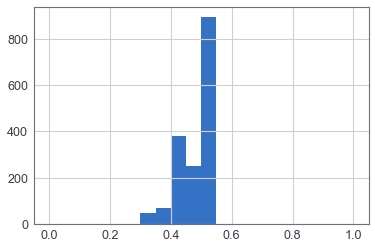

In [19]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20, range=(0.0, 1.0))
plt.show()

In [20]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.483254,0.0418,0.482927,0.019639
1,0.498715,0.0389,0.509346,0.021623
2,0.477778,0.0180,0.515152,0.010117
3,0.476071,0.0397,0.504630,0.021623
4,0.496970,0.0165,0.560440,0.010117
5,0.547059,0.0170,0.618557,0.011902
6,0.531034,0.0145,0.590909,0.010315
7,0.602891,0.1453,0.603799,0.088276
8,0.547455,0.0727,0.542079,0.043444
9,0.510345,0.0145,0.506173,0.008133


#### Saving our training labels
Finally, we'll save the training_marginals, which are our "noise-aware training labels", so that we can use them in the next tutorial to train our end extraction model:

In [21]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 1641 marginals
Wall time: 1.41 s


### Checking performance against development set labels

We will run the labeler on the development set, load in hand labels, then evaluate LF performance.

In [22]:
# gold (human-labeled) development set labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

<102x1 sparse matrix of type '<class 'numpy.int32'>'
	with 89 stored elements in Compressed Sparse Row format>

In [23]:
# Gen Model Metrics
dev_marginals = gen_model.marginals(L_dev)
_ = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.0857
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.0857
F1                   0.158
----------------------------------------
TP: 6 | FP: 0 | TN: 32 | FN: 64



In [24]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_detect,0,0.049020,0.049020,0.049020,3,2,0,0,0.600000,0.501279
LF_infect,1,0.068627,0.009804,0.009804,7,0,0,0,1.000000,0.497525
LF_misc,2,0.058824,0.019608,0.019608,5,1,0,0,0.833333,0.534483
LF_isolate,3,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.489011
LF_v_cause_h,4,0.019608,0.000000,0.000000,2,0,0,0,1.000000,0.476563
LF_v_h,5,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.440994
LF_uncertain,6,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.504505
LF_far_v_h,7,0.117647,0.009804,0.009804,0,0,7,2,0.222222,0.603436
LF_far_h_v,8,0.176471,0.058824,0.029412,0,0,9,8,0.470588,0.550765
LF_neg_h,9,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.464286
